# Introduction and project objective

Introduction

As buildings become increasingly integrated with smart technologies, the need for intelligent and efficient energy management systems is more urgent than ever. In this context, appliance-level energy monitoring stands out as a critical area for achieving energy efficiency, cost savings, and sustainability.

This project aims to address that need by developing a data-driven framework for accurately forecasting energy consumption and estimating the associated costs of individual appliances within a building, using time-series forecasting models.

Project Objective

- Select one top energy consumption appliance from Building 1 at UK-DALE Dataset.
- Evaluate different resampling time intervel options of raw appliance active power data, using the Average Error Per Row as the metric.
- Build and evaluate machine learning models that can forecast one year appliance-level power usage, based on three-year historical time-series data. Using MAE, RMSE, and Total Energy Error in kWh as metrics.
- Apply the machine learning model candidate to forcast future appliance-level power usage and energy cost.

# Data description and EDA findings

## Data Description

UK-DALE (UK Domestic Appliance-Level Electricity) is a publicly available dataset that records domestic electricity usage at both the whole-house and appliance-level in 5 UK homes. The dataset is designed for energy disaggregation, user behavior analysis, and appliance-level forecasting research.

Sampling Rates

- Individual appliances: 6-second resolution

Features

- Timestamped records (UTC-based)
- Real power usage in watts (W)


UK-DALE Household Overview

`Note: House 1 is used for this project, for its longest data history.`

| House     | Number of Submetered Appliances | Data Collection Period        | Sampling Frequency         |
|-----------|----------------------------------|-------------------------------|----------------------------|
| House 1   | 52                               | 09/11/2012 – 26/04/2017       | Mains: 1Hz / Appliances: 6s |
| House 2   | 19                               | 17/02/2013 – 10/10/2013       | Mains: 1Hz / Appliances: 6s |
| House 3   | 4                                | 27/02/2013 – 08/04/2013       | Mains: 1Hz / Appliances: 6s |
| House 4   | 5                                | 09/03/2013 – 01/10/2013       | Mains: 1Hz / Appliances: 6s |
| House 5   | 24                               | 29/06/2014 – 13/11/2014       | Mains: 1Hz / Appliances: 6s |


Data Format and size

`Note: HDF5 Data Format is used for this project, for its memory efficiency advantage.`

| Feature                | Zipped CSV (`.cat`)                                         | HDF5 (`.h5`)                                                  |
|------------------------|-------------------------------------------------------------|---------------------------------------------------------------|
| **File Size**          | ~3.5 GB (compressed)                                        | ~5.9 GB                                                       |
| **Speed (read/write)** | ❌ Slower (especially for large files or many small files)  | ✅ Much faster I/O for large datasets                         |
| **Storage Structure**  | Multiple individual files per appliance or house            | All data stored in a single structured container              |
| **Memory Efficiency**  | ❌ May load entire file into memory                          | ✅ Can load specific chunks or subsets of data                |
| **Best For**           | Simplicity, quick inspection, small subsets                 | Large-scale modeling, machine learning, efficient storage     |
| **Resumable Processing** | ❌ Harder to manage across multiple files                 | ✅ Can easily resume reading/writing with slicing             |
| **Tool Compatibility** | Works with Excel, pandas, etc.                              | Requires HDF5-compatible tools (`pandas`, `h5py`, `PyTables`) |


## EDA

Setup

In [1]:
# Import Packages
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nilmtk as ntk
import sys
import os

# Add customize helper functions for this project
sys.path.append(os.path.abspath("./helper_functions"))
import nilmtk_ukdale as jin

In [2]:
# Define Variables
meter_h5_path = './data/raw/ukdale.h5'
warnings.filterwarnings("ignore")
color_pal = sns.color_palette("tab10")

In [3]:
# Load Dataset
data = ntk.DataSet(meter_h5_path) #load the data from HDF5 file

# Select Building 1 dataset, since it has the longest data history
building = data.buildings[1]
elec = building.elec

### All Appliances

Whole Sample Period

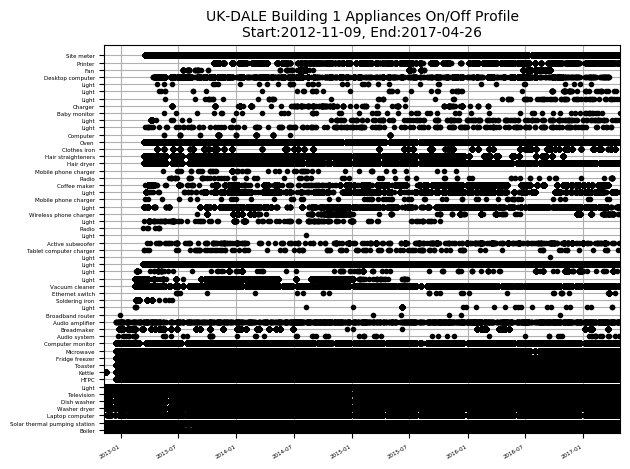

In [ ]:
# Plot the Appliances On/Off Profile for the building during certain time
# Runtime is 32m for the whole period

data.set_window()

elec.plot_when_on(on_power_threshold = 40) #Set a threshold to remove residual power noise when devices are off
plt.title('UK-DALE Building 1 Appliances On/Off Profile\nStart:2012-11-09, End:2017-04-26', fontsize=10)
plt.xticks(fontsize=4)
plt.yticks(fontsize=4)
plt.grid(True)
plt.tight_layout()

plt.savefig('figures/final/B1_overall_AppliancesInUsePlot_whole.png', dpi=300)

One Day

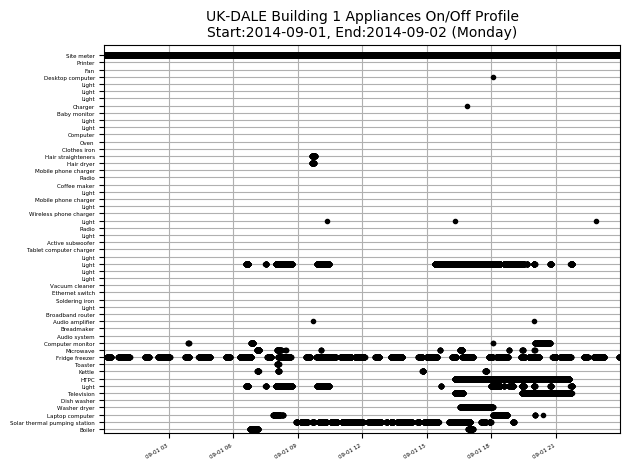

In [5]:
# Plot the Appliances On/Off Profile for the building during certain time

data.set_window(start='2014-09-01', end='2014-09-02')

elec.plot_when_on(on_power_threshold = 40) #Set a threshold to remove residual power noise when devices are off
plt.title('UK-DALE Building 1 Appliances On/Off Profile\nStart:2014-09-01, End:2014-09-02 (Monday)', fontsize=10)
plt.xticks(fontsize=4)
plt.yticks(fontsize=4)
plt.grid(True)
plt.tight_layout()

plt.savefig('figures/final/B1_overall_AppliancesInUsePlot_day.png', dpi=300)

Top 5 Power Usage Appliance

In [ ]:
# Identify Top-k appliances
# 8m to run
data.set_window()
top_train_elec = elec.submeters().select_top_k(k=5)
fraction = top_train_elec.submeters().fraction_per_meter().dropna()

5/5 ElecMeter(instance=8, building=1, dataset='UK-DALE', appliances=[Appliance(type='light', instance=1), Appliance(type='light', instance=2)]) instance=2)])=1)])e=2), Appliance(type='radio', instance=3)])1)])

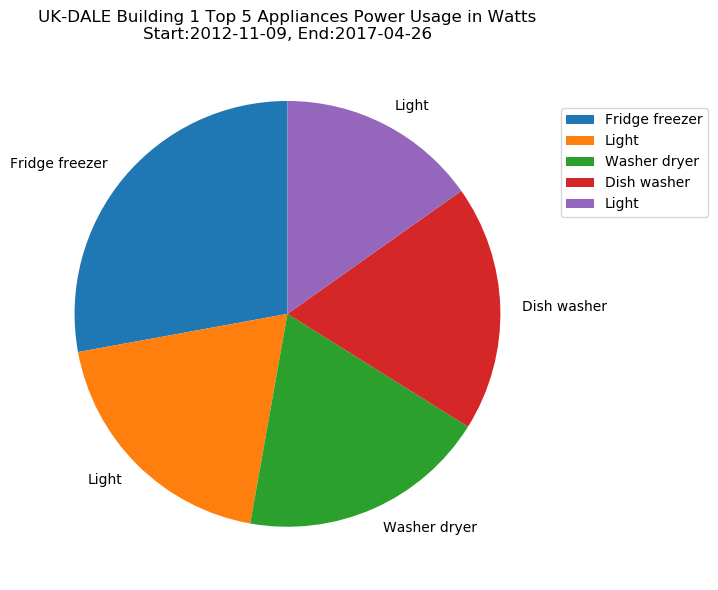

In [7]:
# Create Pie chart of the Top-5 Power Usage Appliances of this building
labels = elec.get_labels(fraction.index)

fig, ax = plt.subplots(figsize=(10, 6))
ax.pie(fraction.values, labels=labels, startangle=90, textprops={'fontsize': 10}, colors = color_pal)
ax.set_ylabel('')

# Set title and legend
plt.title('UK-DALE Building 1 Top 5 Appliances Power Usage in Watts\nStart:2012-11-09, End:2017-04-26')
ax.legend(loc='top right', bbox_to_anchor=(1, 0.9))

# Save the figure
plt.tight_layout()
plt.savefig('figures/final/B1_overall_AppliancesPowerUsagePie_top5.png', dpi=300)

### Appliance - Fridge Freezer

Fridge Freezer is the top 1 appliance power usage in house 1.

In [4]:
# Define variables
app = elec['fridge freezer']

#### Helper Functions

In [5]:
# To load data
def load_UKDALE_data(app, sample_period=6):
    df = app.load(sample_period=sample_period)
    df = pd.concat(list(df))
    df.index.name = 'datetime'
    df.columns = ["_".join(pair) for pair in df.columns]
    return df

def calculate_total_energy(df, power_column='power_active', sample_seconds=6):
    """
    Calculate total energy in kWh from power data.
    
    Parameters:
        df (pd.DataFrame): DataFrame with power readings
        power_column (str): Name of the column with power data
        sample_seconds (int): Sampling interval in seconds
        
    Returns:
        float: Total energy in kWh
    """
    interval_hours = sample_seconds / 3600  # convert seconds to hours
    energy_kwh = (df[power_column].sum()) * interval_hours / 1000  # W to kW
    return energy_kwh

# To compare different resample rates
def resample_compare_plot(sample_period_s = 60*60, sample_cycle = 'Hourly', plot_cycle = '2013-09', resampled_linestyle=':'):
    df_resampled = load_UKDALE_data(app, sample_period=sample_period_s)

    raw_total_energy = app.total_energy()['active'] # kWh
    resampled_total_energy = calculate_total_energy(df_resampled, power_column='power_active', sample_seconds=sample_period_s) # kWh

    labels = ['Raw in 6s', f'Resampled {sample_cycle}']
    values = [raw_total_energy, resampled_total_energy]
    legend_labels = [f"{label}: {value:.2f} kWh, {plot_cycle}" for label, value in zip(labels, values)]

    fig, ax = plt.subplots(figsize=(10, 6))

    app.plot()
    df_resampled.plot(ax=ax, label=f'{sample_cycle} Resampled Data', linestyle=resampled_linestyle)

    ax.set_title(f"Evaluation of Resample Rate over {plot_cycle}\n B1 Fridge freezer Active Power Usage - {sample_cycle}")
    ax.set_ylabel("Power (W)")
    ax.set_xlabel("Datetime")
    ax.legend(labels = legend_labels, loc='upper left', bbox_to_anchor=(0.01, 0.99))

    plt.tight_layout()

    plt.savefig(f'figures/final/B1_fridge_resample_{sample_cycle}_{plot_cycle}.png', dpi=300)
    print(f"✅ Figure saved as ./figures/final/B1_fridge_resample_{sample_cycle}_{plot_cycle}.png.")

    return labels, values

### Resample Rate Evaluation

`Decided to resample with hourly rate to predict future power consumption of this appliance, since it has lower and consistant Relative Error in kWh Per Row across three years.`

The goal of this project is to predict the billing cost for the future, so the aim is to select a resample rate with lower Error per Row.

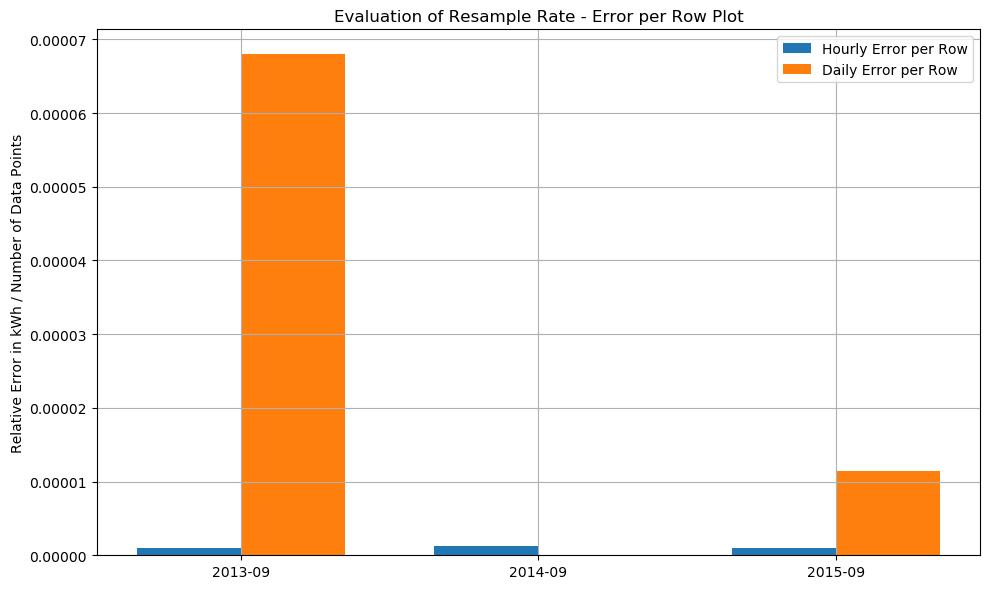

In [6]:
# Data (from past simulations)
years = ['2013-09', '2014-09', '2015-09']
energy_raw = np.array([29.43, 32.42, 29.25])
energy_hourly = np.array([29.45, 32.45, 29.27])
energy_daily = np.array([29.49, 32.42, 29.26])

# Relative Errors
error_hourly = np.abs(energy_hourly - energy_raw) / energy_raw
error_daily = np.abs(energy_daily - energy_raw) / energy_raw

# Data volume
data_rows_hourly = 24 * 30
data_rows_daily = 30

# Cost-Effectiveness (Error per data point)
ce_hourly = error_hourly / data_rows_hourly
ce_daily = error_daily / data_rows_daily

# Plotting
x = np.arange(len(years))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, ce_hourly, width, label='Hourly Error per Row')
bars2 = ax.bar(x + width/2, ce_daily, width, label='Daily Error per Row')

ax.set_ylabel('Relative Error in kWh / Number of Data Points')
ax.set_title('Evaluation of Resample Rate - Error per Row Plot')
ax.set_xticks(x)
ax.set_xticklabels(years)
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.savefig(f'figures/final/B1_fridge_resample_Error_per_Row.png', dpi=300)

Hourly Resample Rate

✅ Figure saved as ./figures/final/B1_fridge_resample_Hourly_2013-09.png.


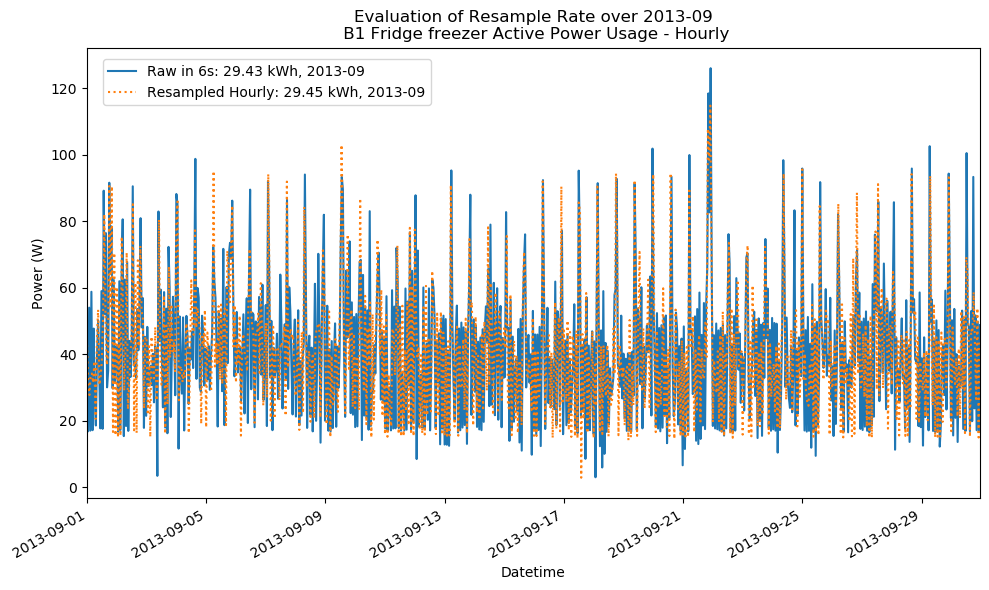

In [7]:
# Variables
data.set_window(start='2013-09-01', end='2013-10-01') #{'start': '2012-11-09T22:28:15+00:00', 'end': '2017-04-26T18:35:53+01:00'}
sample_period_s = 60*60
sample_cycle = 'Hourly'
plot_cycle = '2013-09'
resampled_linestyle=':'

labels, values = resample_compare_plot(sample_period_s, sample_cycle, plot_cycle, resampled_linestyle)

Daily Resample Rate

✅ Figure saved as ./figures/final/B1_fridge_resample_Daily_2013-09.png.


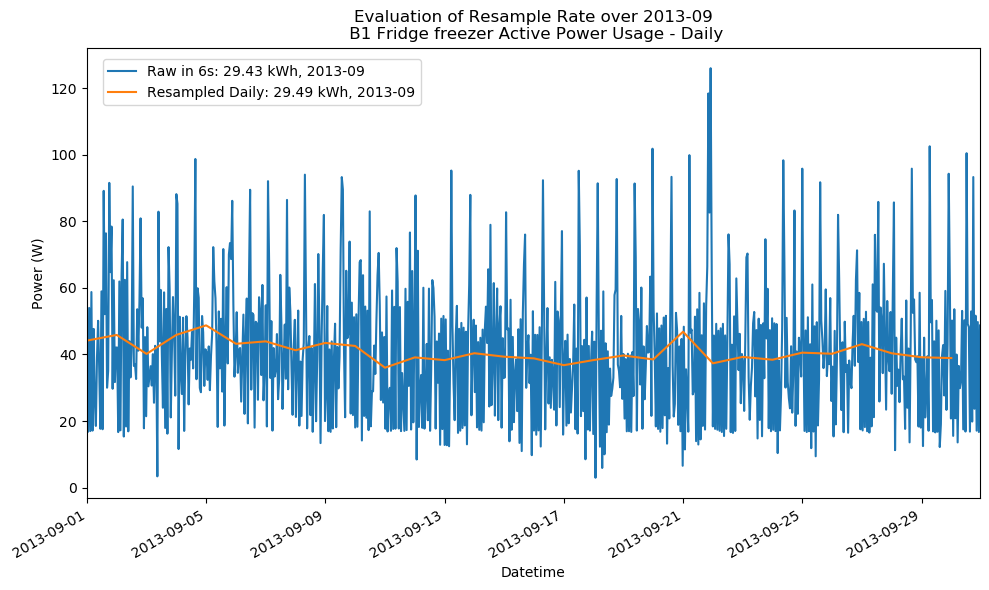

In [8]:
# Variables
data.set_window(start='2013-09-01', end='2013-10-01') #{'start': '2012-11-09T22:28:15+00:00', 'end': '2017-04-26T18:35:53+01:00'}
sample_period_s = 24*60*60
sample_cycle = 'Daily'
plot_cycle = '2013-09'
resampled_linestyle='-'

labels, values = resample_compare_plot(sample_period_s, sample_cycle, plot_cycle, resampled_linestyle)

# Methodology

## Data Preprocessing

### Load and Clean Data

Load Resampled Data - Hourly

In [9]:
data.set_window()
gap_time = 60*60
app = elec['fridge freezer']
df = load_UKDALE_data(app, sample_period=gap_time)

#### Index Datetime Format

In [10]:
isinstance(df.index, pd.DatetimeIndex)

True

#### Abnormal Meters

`No abnormal readings are detected.`

- Readings above 4 kW for Individual Appliance Monitors (IAMs) and above 20 kW for whole-house readings are filtered out as they are considered spurious. These thresholds are set above the safe maximum power draw for a UK mains appliance and the maximum whole house power reading recorded, respectively. 

- All readings should be greater or equal to 0 watt.

Ref: Kelly, J. and Knottenbelt, W. (2015). The UK-DALE dataset, domestic appliance-level electricity demand and whole-house demand from five UK homes. Scientific Data, [online] 2(1). doi:https://doi.org/10.1038/sdata.2015.7.

In [11]:
# Idenfity appliance value > 4000 watts
len(df.query("`power_active` >= 4000"))

0

In [12]:
# Idenfity appliance value < 0 watts
len(df.query("`power_active` < 0"))

0

#### Missing Values

`All 741 / 38252 missing values are treated with the following rules:`

- null gap > 2 minutes, off-mode, replace with 0

- null gap < 2 minutes, signal-loss, forward-filling

Ref: Kelly, J. and Knottenbelt, W. (2015). The UK-DALE dataset, domestic appliance-level electricity demand and whole-house demand from five UK homes. Scientific Data, [online] 2(1). doi:https://doi.org/10.1038/sdata.2015.7.

In [13]:
df.isnull().sum()

power_active    741
dtype: int64

In [14]:
max_gap_minute = 2 # Variable

df_ref = jin.add_gap_column(df, column_name='power_active', gap_time=gap_time)

# Replace missing values based on the duration of the length of each continous gap
df_clean = jin.clean_power_data(df, df_ref, max_gap_minute, column_name='power_active')

In [15]:
df_clean.isnull().sum()

power_active    0
dtype: int64

### Prepare Data for train, validate, test

`Using chronological split for time-series problem.`

- Train: 2012-11-09 >> 2016-01-01
- Validate: 2016-01-01 >> 2017-01-01
- Test: 2017-01-01 >> 2017-04-26

Setup

In [16]:
# Sort by time
df_clean = df_clean.sort_index()

# Convert 'datetime' column to datetime format
df_clean.index = pd.to_datetime(df_clean.index)

Data Split

In [17]:
train = df_clean.loc[df_clean.index < '2016-01-01'] 
val = df_clean.loc[(df_clean.index >= '2016-01-01') & (df_clean.index < '2017-01-01')] 
test = df_clean.loc[df_clean.index >= '2017-01-01']

Visualization

`3 years of training data, 1 year of validation data, and 4 months of test data.`

To avoid seeing the test set which affect decisions, this project only plot train and validation sets here.

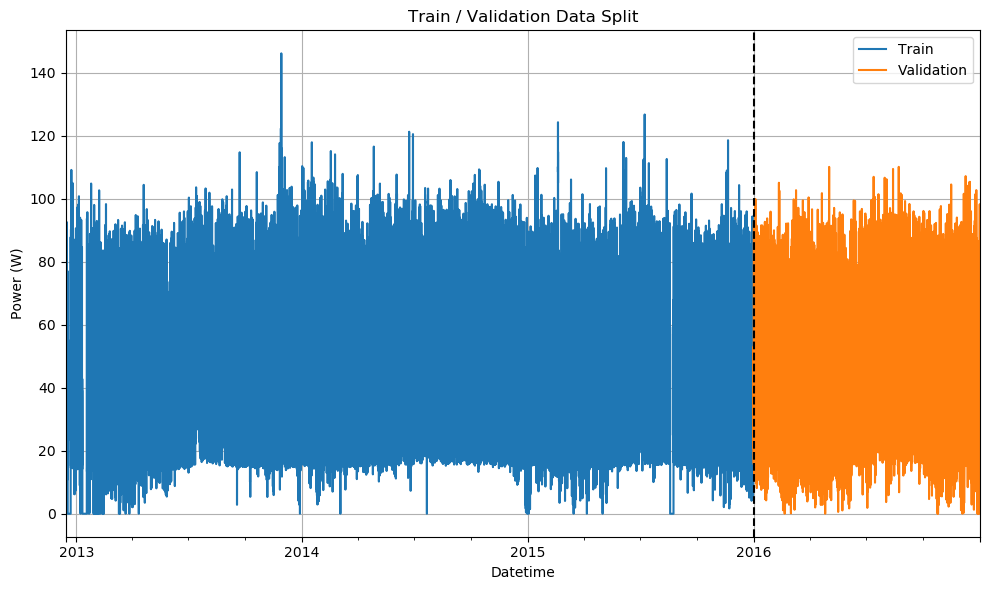

In [18]:
# Plot the data split of train and validation
# Runtime: 3m2.7s
fig, ax = plt.subplots(figsize=(10, 6))

train.plot(ax=ax, label='Train')
val.plot(ax=ax, label='Validation')
ax.axvline('2016-01-01', color='black', ls='--')

ax.set_title('Train / Validation Data Split')
ax.set_ylabel("Power (W)")
ax.set_xlabel("Datetime")
ax.legend(['Train', 'Validation'])
ax.grid(True)

plt.tight_layout()
plt.savefig(f'figures/final/B1_fridge_train_val_split.png', dpi=300)

### Feature Engineering

`Using time features to build Models to research on the how the patterns of time (minute, hour, day, weekday, month) affect the power usage patterns of individual appliances.`

In [19]:
df_train = train.copy()
df_val = val.copy()

# Define features
def create_features(df_eng):
    '''
    Create time seres features based on time series index.
    '''
    df_eng['hour'] = df_eng.index.hour
    df_eng['weekday'] = df_eng.index.weekday # The day of the week with Monday=0, Sunday=6.
    df_eng['quarter'] = df_eng.index.quarter
    df_eng['day'] = df_eng.index.day
    df_eng['month'] = df_eng.index.month
    df_eng['year'] = df_eng.index.year

    return df_eng

df_train = create_features(df_train)
df_val = create_features(df_val)

In [20]:
# Define Machine Learning Model Columns
target_col = 'power_active'

predictor_cols = [
    'hour', 
    'weekday', 
    'quarter',
    'day',
    'month',
    'year',
    ]

In [21]:
X_train = df_train[predictor_cols]
y_train = df_train[target_col]

X_val = df_val[predictor_cols]
y_val = df_val[target_col]

## Model Selection & Evaluation

Model Evaluation Metrics

1. `Energy difference in kWh per month` – for cost-relevant evaluation - main metric
2. MAE – for average error magnitude
3. RMSE – to catch models that underperform on spikes

### Iteration 1 - Selection

Machine Learning Model Candidates: `Decision Tree`, `Random Forest `,  `XGBoost`.

Decision Tree

In [22]:
from sklearn.tree import DecisionTreeRegressor

# Initialize
tree_regressor = DecisionTreeRegressor(random_state=42)

In [23]:
# Fit the regressor to the training data:
tree_regressor.fit(X_train, y_train) #0.1s

DecisionTreeRegressor(random_state=42)

In [24]:
time_tree = '0.1s'

Random Forest

In [25]:
from sklearn.ensemble import RandomForestRegressor

# Initialize
forest_regressor = RandomForestRegressor(random_state=42)

In [26]:
# Fit the regressor to the training data:
forest_regressor.fit(X_train, y_train) #4.8s

RandomForestRegressor(random_state=42)

In [27]:
time_forest = '4.8s'

XGBoost

In [28]:
import xgboost as xgb

# Initialize
xgb_regressor = xgb.XGBRegressor(seed=42)

In [29]:
# Fit the regressor to the training data:
xgb_regressor.fit(X_train, y_train) #0.9s

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [30]:
time_xgb = '0.9s'

### Iteration 1 - Evaluation

1. Energy difference in kWh per month – `XGBoost` is the Winner!
2. MAE – `XGBoost` is the Winner!
3. RMSE – `XGBoost` is the Winner!

Setup

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [32]:
# Define Variables
regressors = {
    "Decision Tree": tree_regressor,
    "Random Forest": forest_regressor,
    "XGBoost": xgb_regressor
}
train_times_str = [time_tree, time_forest, time_xgb]

metrics = [mean_absolute_error, jin.root_mean_squared_error] # root_mean_squared_error, mean_squared_error, mean_absolute_error
metrics_name = ['MAE (W)', 'RMSE (W)']

# Evaluation metrics
models, y_preds, metric_results, train_time = jin.evaluate_reg_models(
                                                        regressors, 
                                                        X_val, 
                                                        y_val, 
                                                        metrics, 
                                                        train_times_str)

In [33]:
# Define data for evaluation
models = models
y_preds = y_preds
metrics_name = metrics_name
train_time = train_time # in seconds
val_mae = metric_results['mean_absolute_error']
val_rmse = metric_results['root_mean_squared_error']

Predicted Energy Error per Month Plot

In [34]:
# Calculate Error of Energy from Predited to Ground Truth in kWh for each month
error_kWh_per_month = {
    model: ((y_pred - y_val) / 1000).resample('M').sum()
    for model, y_pred in y_preds.items()
}

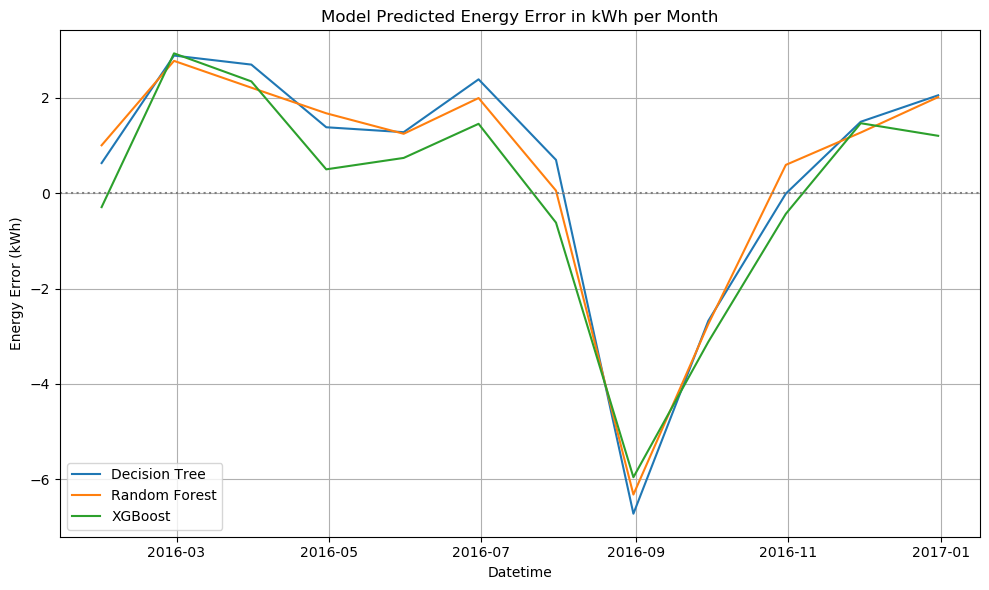

In [35]:
# Create figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot All models by loop through models and plot their error time series
model_to_plot = 'all'
for model, error_series in error_kWh_per_month.items():
    ax.plot(error_series.index, error_series.values, label=model)

# # Select One model to plot
# model_to_plot = 'XGBoost'
# error_series = error_kWh_per_month[model_to_plot]
# plt.plot(error_series.index, error_series.values, label=model_to_plot, color='red')

# Add labels and title
ax.set_xlabel('Datetime')
ax.set_ylabel('Energy Error (kWh)')
ax.set_title('Model Predicted Energy Error in kWh per Month')
ax.legend()
ax.grid(True)
ax.axhline(0, color='grey', ls=':')

# ax.set_xlim(pd.to_datetime(duration[0]), pd.to_datetime(duration[1]))

plt.tight_layout()

plt.savefig(f'figures/final/B1_fridge_train_val_evaluation_error_{model_to_plot}.png', dpi=300)

RMSE

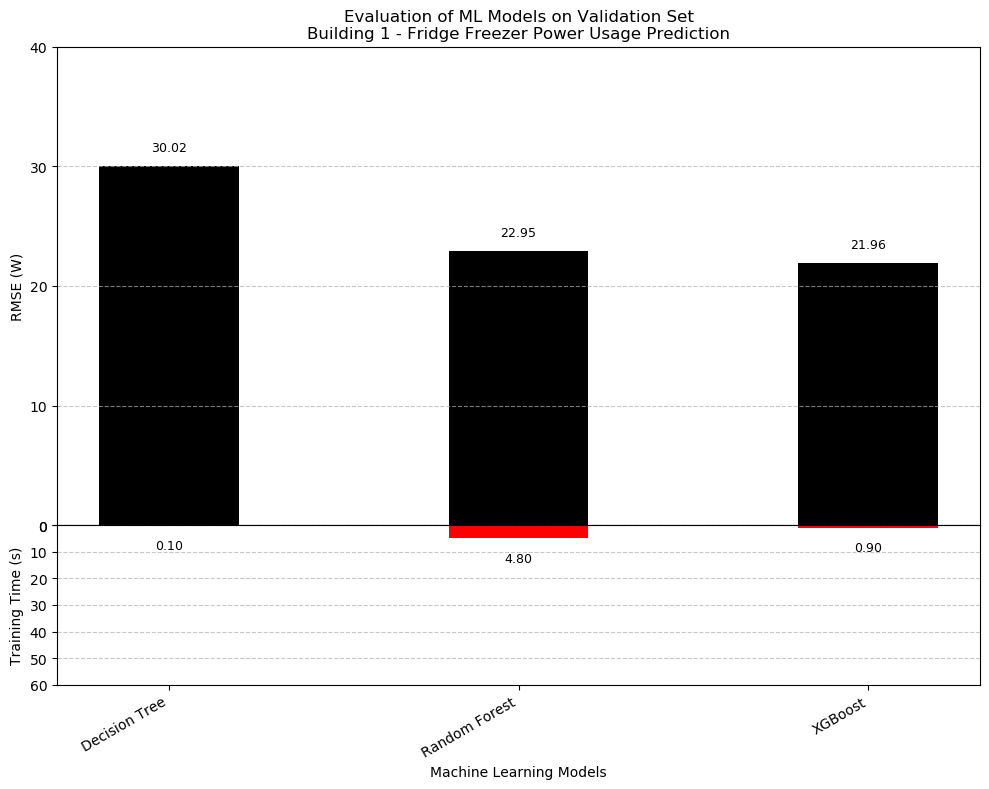

In [36]:
# Plot an evaluation diagram for models based on Validation Set
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax1.set_title('Evaluation of ML Models on Validation Set\nBuilding 1 - Fridge Freezer Power Usage Prediction')
bars1 = ax1.bar(models, val_rmse, width=0.4, color='black')
ax1.set_ylabel(metrics_name[1])
ax1.grid(axis='y', ls='--', alpha=0.7)

bars2 = ax2.bar(models, train_time ,width=0.4, color='red')
ax2.set_xlabel('Machine Learning Models')
ax2.set_ylabel('Training Time (s)')


##-----------Display Numbers------------##
# Add labels on top of ax1 bars (RMSE)
for bar, value in zip(bars1, val_rmse):
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 1,               # Adjust space above the bar
        f'{value:.2f}',
        ha='center', va='bottom', fontsize=9, fontweight='normal'
    )

# Add labels on top of ax2 bars (Computing Time)
for bar, value in zip(bars2, train_time):
    ax2.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 10,                # Adjust space above the bar
        f'{value:.2f}',
        ha='center', va='bottom', fontsize=9, fontweight='normal'
    )
##--------------------------------------##

ax1.set_yticks(range(0, 50, 10))
ax2.set_yticks(range(0, 70, 10))
ax2.grid(axis='y', ls='--', alpha=0.7)
ax2.invert_yaxis()

fig.autofmt_xdate()

plt.tight_layout()
plt.subplots_adjust(hspace=0)  # Tightens space between subplots

plt.savefig(f'figures/final/B1_fridge_train_val_evaluation_{metrics_name[1]}.png', dpi=300)

MAE

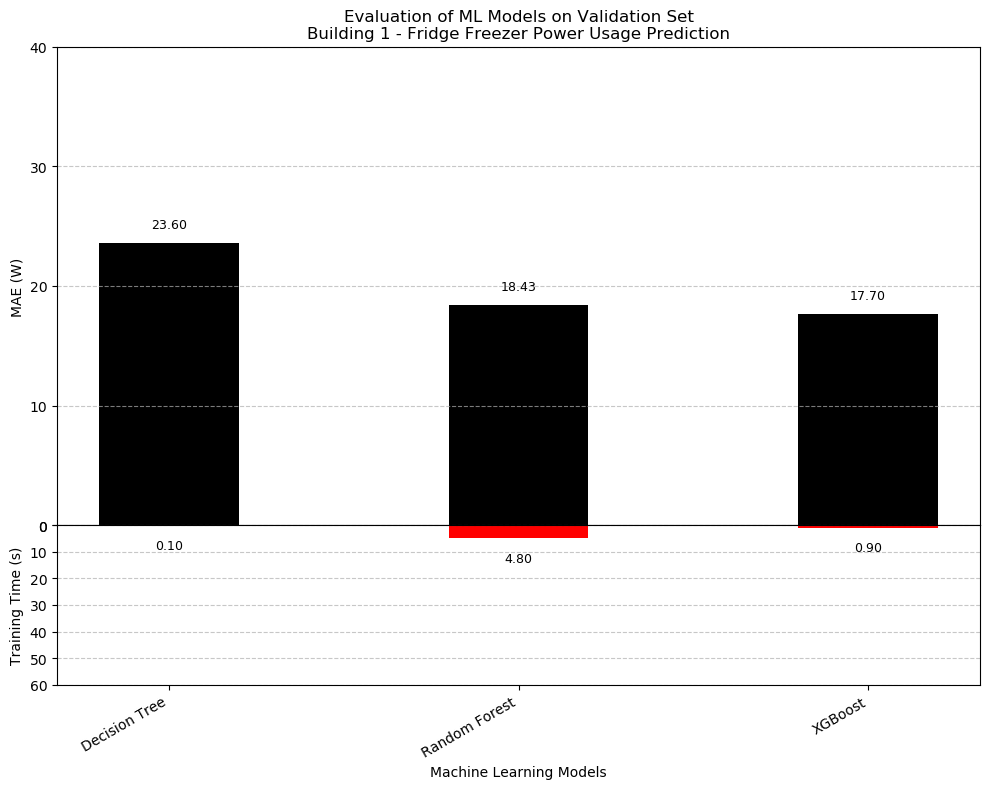

In [40]:
# Plot an evaluation diagram for models based on Validation Set
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax1.set_title('Evaluation of ML Models on Validation Set\nBuilding 1 - Fridge Freezer Power Usage Prediction')
bars1 = ax1.bar(models, val_mae, width=0.4, color='black')
ax1.set_ylabel(metrics_name[0])
ax1.grid(axis='y', ls='--', alpha=0.7)

bars2 = ax2.bar(models, train_time ,width=0.4, color='red')
ax2.set_xlabel('Machine Learning Models')
ax2.set_ylabel('Training Time (s)')


##-----------Display Numbers------------##
# Add labels on top of ax1 bars (MSE)
for bar, value in zip(bars1, val_mae):
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 1,               # Adjust space above the bar
        f'{value:.2f}',
        ha='center', va='bottom', fontsize=9, fontweight='normal'
    )

# Add labels on top of ax2 bars (Computing Time)
for bar, value in zip(bars2, train_time):
    ax2.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 10,                # Adjust space above the bar
        f'{value:.2f}',
        ha='center', va='bottom', fontsize=9, fontweight='normal'
    )
##-------------------------------------##

ax1.set_yticks(range(0, 50, 10))
ax2.set_yticks(range(0, 70, 10))
ax2.grid(axis='y', ls='--', alpha=0.7)
ax2.invert_yaxis()

fig.autofmt_xdate()

plt.tight_layout()
plt.subplots_adjust(hspace=0)  # Tightens space between subplots

plt.savefig(f'figures/final/B1_fridge_train_val_evaluation_{metrics_name[0]}.png', dpi=300)

Plot

In [41]:
# Define Variables
day_duration = ['2016-09-01', '2016-09-02']
week_duration = ['2016-09-02', '2016-09-08']
year_duration = ['2016-01-01', '2017-01-01']

predictions_dict = {
    "Decision Tree": tree_regressor.predict(X_val),
    "Random Forest": forest_regressor.predict(X_val),
    "XGBoost": xgb_regressor.predict(X_val),
}

✅ Figure saved as ./figures/final/B1_fridge_val_1_all_models_Day.png.


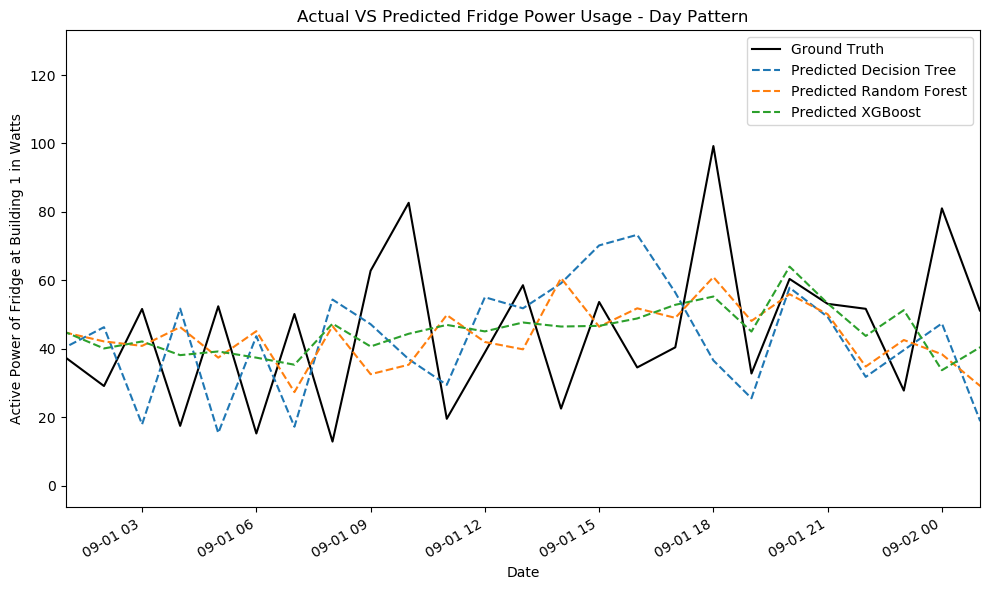

In [43]:
# Plot predicted patterns for all models
cycle = 'Day' # Change this

jin.plot_data_multiple_models(
    predictions_dict,
    X_train, y_train,
    X_val, y_val,
    cycle=cycle,
    duration=day_duration, # Change this
    iteration=1
)

✅ Figure saved as ./figures/final/B1_fridge_val_1_all_models_Year.png.


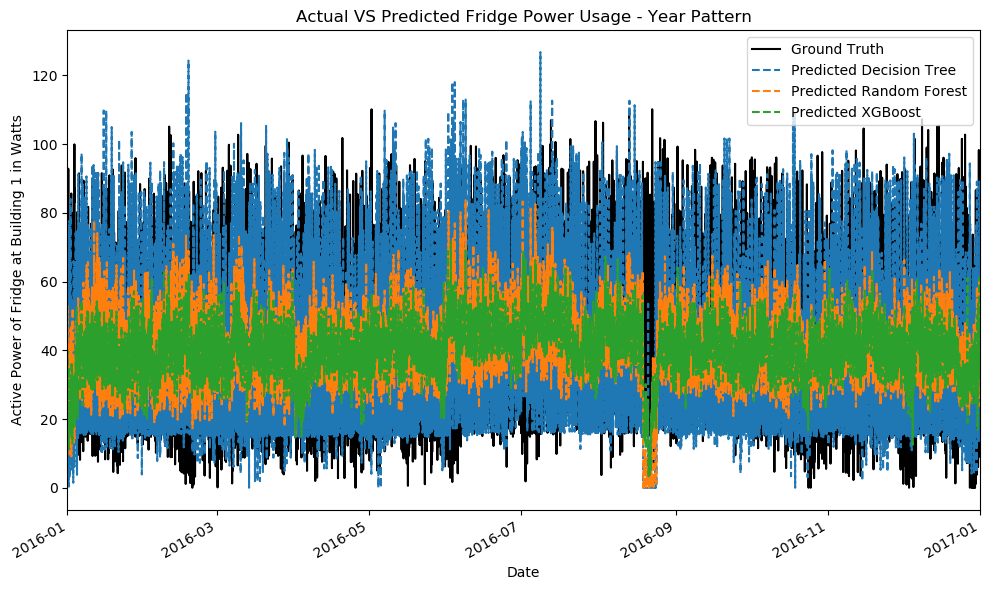

In [45]:
# Plot predicted patterns for all models
cycle = 'Year' # Change this

jin.plot_data_multiple_models(
    predictions_dict,
    X_train, y_train,
    X_val, y_val,
    cycle=cycle,
    duration=year_duration, # Change this
    iteration=1
)

✅ Figure saved as ./figures/final/B1_fridge_1_val_XGBoost_Day.png.


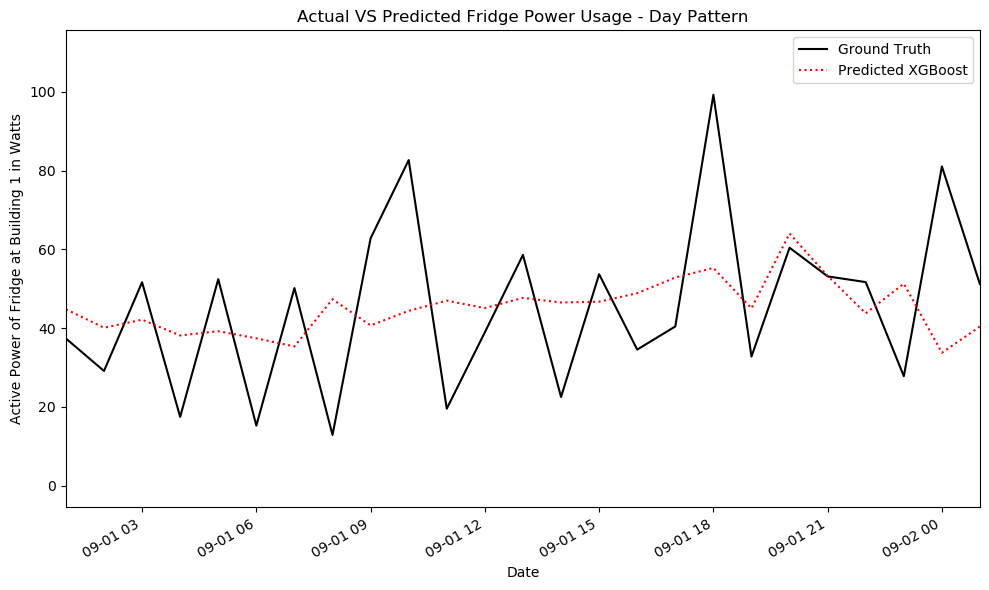

In [47]:
# Single Plot
y_pred = xgb_regressor.predict(X_val)
model = 'XGBoost'
cycle = 'Day'
duration_single = day_duration

jin.plot_data(y_pred=y_pred, X_fact=X_val, y_fact=y_val, model=model, cycle=cycle, duration=duration_single, stage="val", iteration=1)

### Iteration 2 - Selection

Machine Learning Model: `XGBoost`.

Hyperparameter Tuning: `Manual`, `Optuna`.

XGBoost - Manual

In [48]:
# Initialize & Train
xgb_regressor_manual = xgb.XGBRegressor(seed=42, n_estimators=30, learning_rate=0.1)
xgb_regressor_manual.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        early_stopping_rounds=50,
        verbose=True #Print result for every trail for evaluation
        )

[0]	validation_0-rmse:41.19626	validation_1-rmse:41.16037
[1]	validation_0-rmse:38.15303	validation_1-rmse:38.14332
[2]	validation_0-rmse:35.49640	validation_1-rmse:35.47615
[3]	validation_0-rmse:33.18414	validation_1-rmse:33.19472


[4]	validation_0-rmse:31.18695	validation_1-rmse:31.19127
[5]	validation_0-rmse:29.46504	validation_1-rmse:29.50368
[6]	validation_0-rmse:27.98678	validation_1-rmse:28.05490
[7]	validation_0-rmse:26.72988	validation_1-rmse:26.82855
[8]	validation_0-rmse:25.65844	validation_1-rmse:25.78559
[9]	validation_0-rmse:24.75504	validation_1-rmse:24.92465
[10]	validation_0-rmse:23.98576	validation_1-rmse:24.20171
[11]	validation_0-rmse:23.34660	validation_1-rmse:23.60719
[12]	validation_0-rmse:22.80345	validation_1-rmse:23.11462
[13]	validation_0-rmse:22.35192	validation_1-rmse:22.70507
[14]	validation_0-rmse:21.98268	validation_1-rmse:22.37153
[15]	validation_0-rmse:21.67498	validation_1-rmse:22.09223
[16]	validation_0-rmse:21.41375	validation_1-rmse:21.87262
[17]	validation_0-rmse:21.16954	validation_1-rmse:21.72736
[18]	validation_0-rmse:20.98686	validation_1-rmse:21.60296
[19]	validation_0-rmse:20.83942	validation_1-rmse:21.48195
[20]	validation_0-rmse:20.71797	validation_1-rmse:21.38577
[21

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=30, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [49]:
time_xgb_manual = '0.3s'

XGBoost - Grid Search

In [50]:
from sklearn.model_selection import GridSearchCV

In [51]:
# Setup
xgboost_params = {
    'XGBoost': {
        'model': xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
        'params': {
            'n_estimators': [10, 100],               # number of boosting rounds
            'max_depth': [3,5,10],                   # maximum tree depth
            'learning_rate': [0.01, 0.1, 0.3],        # step size shrinkage
        }
    }
}

def perform_grid_search(parameters):
    results = {}
    for name, setup in parameters.items():
        grid_search = GridSearchCV(
            setup['model'], setup['params'], cv=3, scoring='neg_mean_squared_error', n_jobs=1)
        grid_search.fit(X_train, y_train)
        results[name] = {
            'best_score': grid_search.best_score_,
            'best_params': grid_search.best_params_
        }
    return results

In [52]:
# Find
perform_grid_search(xgboost_params) # 16s

# {'XGBoost': {'best_score': -456.9093831380208,
#   'best_params': {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 10}}}

{'XGBoost': {'best_score': -456.9093831380208,
  'best_params': {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 10}}}

In [53]:
# Train
xgb_regressor_grid = xgb.XGBRegressor(seed=42, n_estimators=10, max_depth=3, learning_rate=0.3)

In [54]:
# Fit the regressor to the training data:
xgb_regressor_grid.fit(X_train, y_train) # 0.1s

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.3, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=10, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [55]:
time_xgb_grid = '16.5s'

XGBoost - Optuna

In [56]:
import optuna

In [57]:
# Setup
NUMBER_OF_TRIALS = 100

def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 10, 100)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)

    # Define the model
    model = xgb.XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        seed=42
    )

    # Fit and evaluate
    model.fit(X_train, y_train)
    y_pred_forest_tuned = model.predict(X_val)
    mse_forest_tuned = mean_squared_error(y_val, y_pred_forest_tuned)
    return mse_forest_tuned  # minimize this

# Create a study object that will find the hyperparameters that minimize the objective
study = optuna.create_study(direction='minimize') # minimizing MSE

[I 2025-04-25 11:14:57,627] A new study created in memory with name: no-name-74ee9ca7-a712-4e4a-8c07-fd598e94accd


In [58]:
# Find
study.optimize(objective, n_trials=NUMBER_OF_TRIALS) # 32.6s

[I 2025-04-25 11:15:01,845] Trial 0 finished with value: 445.2073059082031 and parameters: {'n_estimators': 85, 'max_depth': 4, 'learning_rate': 0.17693178116785138}. Best is trial 0 with value: 445.2073059082031.
[I 2025-04-25 11:15:02,216] Trial 1 finished with value: 467.9797058105469 and parameters: {'n_estimators': 51, 'max_depth': 6, 'learning_rate': 0.2630415708336738}. Best is trial 0 with value: 445.2073059082031.
[I 2025-04-25 11:15:02,508] Trial 2 finished with value: 455.2992248535156 and parameters: {'n_estimators': 57, 'max_depth': 5, 'learning_rate': 0.03727148868329977}. Best is trial 0 with value: 445.2073059082031.
[I 2025-04-25 11:15:02,751] Trial 3 finished with value: 459.6642150878906 and parameters: {'n_estimators': 49, 'max_depth': 5, 'learning_rate': 0.296634297849507}. Best is trial 0 with value: 445.2073059082031.
[I 2025-04-25 11:15:03,505] Trial 4 finished with value: 516.921630859375 and parameters: {'n_estimators': 98, 'max_depth': 8, 'learning_rate': 0.2

In [59]:
# Fetch the best parameters and the best score achieved
best_params = study.best_params
best_score = study.best_value

print("Best score:", best_score)
print("Best parameters:", best_params)

# Best score: 432.9178771972656
# Best parameters: {'n_estimators': 85, 'max_depth': 3, 'learning_rate': 0.06542575429050752}

Best score: 432.7373352050781
Best parameters: {'n_estimators': 59, 'max_depth': 3, 'learning_rate': 0.10812848093034519}


In [60]:
# Train
xgb_regressor_optuna = xgb.XGBRegressor(seed=42, n_estimators=85, max_depth=3, learning_rate=0.065)

In [61]:
# Fit the regressor to the training data:
xgb_regressor_optuna.fit(X_train, y_train) # 0.2s

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.065, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=85, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [62]:
time_xgb_optuna = '32.8s'

### Iteration 2 - Evaluation

1. Energy difference in kWh per month – `Optuna`, `Grid Search` are in a tie!
2. MAE – `Optuna` < `Grid Search`, but are in a tie!
3. RMSE – `Optuna` < `Grid Search`, but are in a tie!

Setup

In [63]:
xgb_regressor_manual

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=30, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [64]:
train_times_str = [time_xgb, time_xgb_manual, time_xgb_grid, time_xgb_optuna]
train_times_str

['0.9s', '0.3s', '16.5s', '32.8s']

In [65]:
# Define Variables
regressors = {
    "XGBoost": xgb_regressor,
    "XGBoost-Manual": xgb_regressor_manual,
    "XGBoost-Grid Search": xgb_regressor_grid,
    "XGBoost-Optuna": xgb_regressor_optuna
}
train_times_str = [time_xgb, time_xgb_manual, time_xgb_grid, time_xgb_optuna]

metrics = [mean_absolute_error, jin.root_mean_squared_error] # root_mean_squared_error, mean_squared_error, mean_absolute_error
metrics_name = ['MAE (W)', 'RMSE (W)']

# Evaluation metrics
models, y_preds, metric_results, train_time = jin.evaluate_reg_models(
                                                        regressors, 
                                                        X_val, 
                                                        y_val, 
                                                        metrics, 
                                                        train_times_str)

In [66]:
# Define data for evaluation
models = models
y_preds = y_preds
metrics_name = metrics_name
train_time = train_time # in seconds
val_mae = metric_results['mean_absolute_error']
val_rmse = metric_results['root_mean_squared_error']

Predicted Energy Error per Month Plot

In [67]:
# Calculate Error of Energy from Predited to Ground Truth in kWh for each month
error_kWh_per_month = {
    model: ((y_pred - y_val) / 1000).resample('M').sum()
    for model, y_pred in y_preds.items()
}

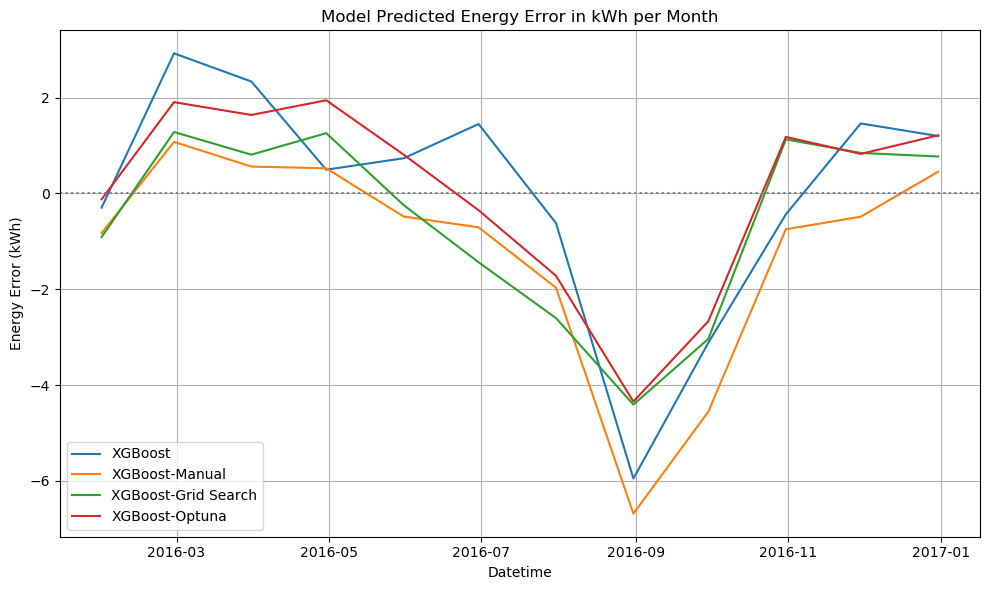

In [68]:
# Create figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot All models by loop through models and plot their error time series
model_to_plot = 'all'
for model, error_series in error_kWh_per_month.items():
    ax.plot(error_series.index, error_series.values, label=model)

# # Select One model to plot
# model_to_plot = 'XGBoost'
# error_series = error_kWh_per_month[model_to_plot]
# plt.plot(error_series.index, error_series.values, label=model_to_plot, color='red')

# Add labels and title
ax.set_xlabel('Datetime')
ax.set_ylabel('Energy Error (kWh)')
ax.set_title('Model Predicted Energy Error in kWh per Month')
ax.legend()
ax.grid(True)
ax.axhline(0, color='grey', ls=':')

# ax.set_xlim(pd.to_datetime(duration[0]), pd.to_datetime(duration[1]))

plt.tight_layout()

plt.savefig(f'figures/final/B1_fridge_train_val_evaluation_2_error_{model_to_plot}.png', dpi=300)

RMSE

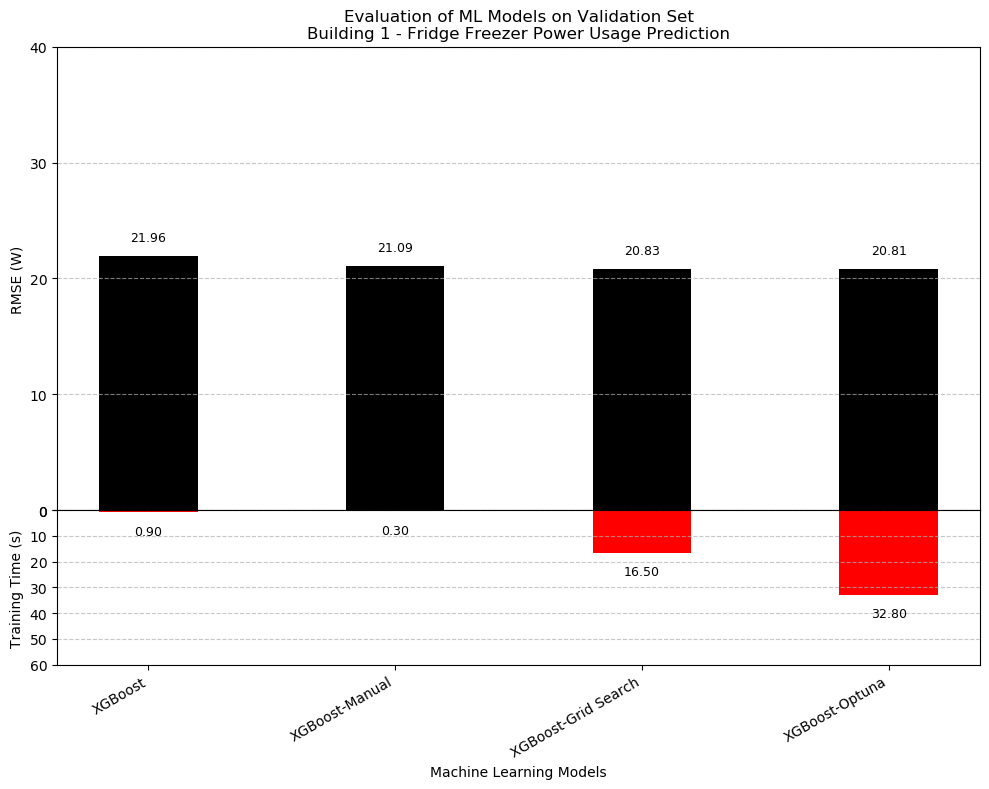

In [69]:
# Plot an evaluation diagram for models based on Validation Set
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax1.set_title('Evaluation of ML Models on Validation Set\nBuilding 1 - Fridge Freezer Power Usage Prediction')
bars1 = ax1.bar(models, val_rmse, width=0.4, color='black')
ax1.set_ylabel(metrics_name[1])
ax1.grid(axis='y', ls='--', alpha=0.7)

bars2 = ax2.bar(models, train_time ,width=0.4, color='red')
ax2.set_xlabel('Machine Learning Models')
ax2.set_ylabel('Training Time (s)')


##-----------Display Numbers------------##
# Add labels on top of ax1 bars (RMSE)
for bar, value in zip(bars1, val_rmse):
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 1,               # Adjust space above the bar
        f'{value:.2f}',
        ha='center', va='bottom', fontsize=9, fontweight='normal'
    )

# Add labels on top of ax2 bars (Computing Time)
for bar, value in zip(bars2, train_time):
    ax2.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 10,                # Adjust space above the bar
        f'{value:.2f}',
        ha='center', va='bottom', fontsize=9, fontweight='normal'
    )
##--------------------------------------##

ax1.set_yticks(range(0, 50, 10))
ax2.set_yticks(range(0, 70, 10))
ax2.grid(axis='y', ls='--', alpha=0.7)
ax2.invert_yaxis()

fig.autofmt_xdate()

plt.tight_layout()
plt.subplots_adjust(hspace=0)  # Tightens space between subplots

plt.savefig(f'figures/final/B1_fridge_train_val_evaluation_2_{metrics_name[1]}.png', dpi=300)

MAE

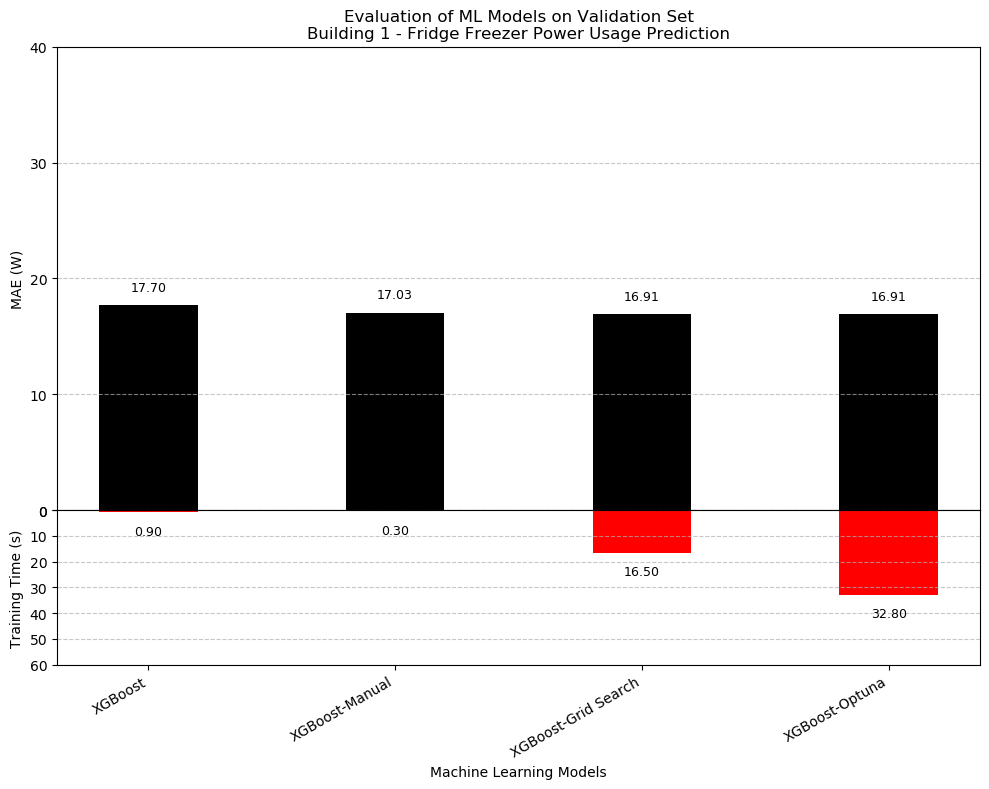

In [70]:
# Plot an evaluation diagram for models based on Validation Set
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax1.set_title('Evaluation of ML Models on Validation Set\nBuilding 1 - Fridge Freezer Power Usage Prediction')
bars1 = ax1.bar(models, val_mae, width=0.4, color='black')
ax1.set_ylabel(metrics_name[0])
ax1.grid(axis='y', ls='--', alpha=0.7)

bars2 = ax2.bar(models, train_time ,width=0.4, color='red')
ax2.set_xlabel('Machine Learning Models')
ax2.set_ylabel('Training Time (s)')


##-----------Display Numbers------------##
# Add labels on top of ax1 bars (MSE)
for bar, value in zip(bars1, val_mae):
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 1,               # Adjust space above the bar
        f'{value:.2f}',
        ha='center', va='bottom', fontsize=9, fontweight='normal'
    )

# Add labels on top of ax2 bars (Computing Time)
for bar, value in zip(bars2, train_time):
    ax2.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 10,                # Adjust space above the bar
        f'{value:.2f}',
        ha='center', va='bottom', fontsize=9, fontweight='normal'
    )
##-------------------------------------##

ax1.set_yticks(range(0, 50, 10))
ax2.set_yticks(range(0, 70, 10))
ax2.grid(axis='y', ls='--', alpha=0.7)
ax2.invert_yaxis()

fig.autofmt_xdate()

plt.tight_layout()
plt.subplots_adjust(hspace=0)  # Tightens space between subplots

plt.savefig(f'figures/final/B1_fridge_train_val_evaluation_2_{metrics_name[0]}.png', dpi=300)

Plot

In [71]:
# Define Variables
day_duration = ['2016-09-01', '2016-09-02']
week_duration = ['2016-09-02', '2016-09-08']
year_duration = ['2016-01-01', '2017-01-01']

predictions_dict = {
    "XGBoost": xgb_regressor.predict(X_val),
    "XGBoost-Manual": xgb_regressor_manual.predict(X_val),
    "XGBoost-Grid Search": xgb_regressor_grid.predict(X_val),
    "XGBoost-Optuna": xgb_regressor_optuna.predict(X_val)
}

✅ Figure saved as ./figures/final/B1_fridge_val_2_all_models_Day.png.


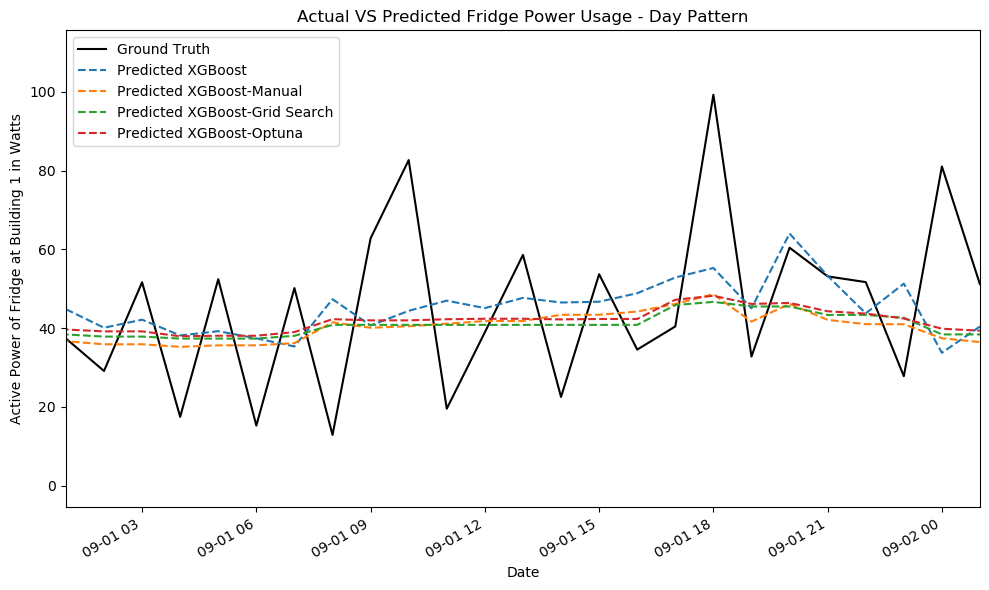

In [72]:
# Plot predicted patterns for all models
cycle = 'Day' # Change this

jin.plot_data_multiple_models(
    predictions_dict,
    X_train, y_train,
    X_val, y_val,
    cycle=cycle,
    duration=day_duration, # Change this
    iteration=2 # Change this
)

✅ Figure saved as ./figures/final/B1_fridge_val_2_all_models_Year.png.


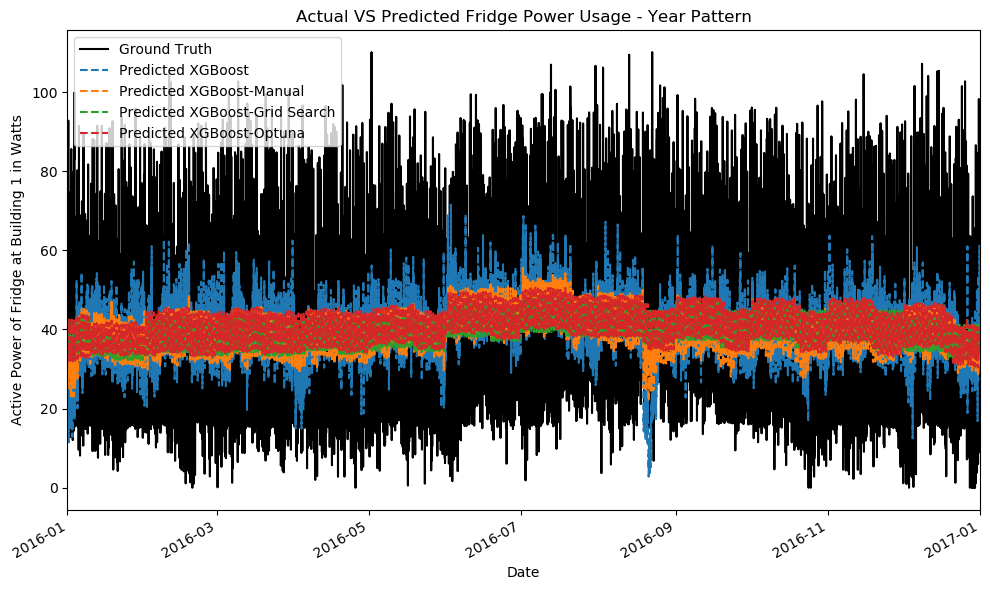

In [73]:
# Plot predicted patterns for all models
cycle = 'Year' # Change this

jin.plot_data_multiple_models(
    predictions_dict,
    X_train, y_train,
    X_val, y_val,
    cycle=cycle,
    duration=year_duration, # Change this
    iteration=2 # Change this
)

✅ Figure saved as ./figures/final/B1_fridge_2_val_XGBoost-Optuna_Day.png.


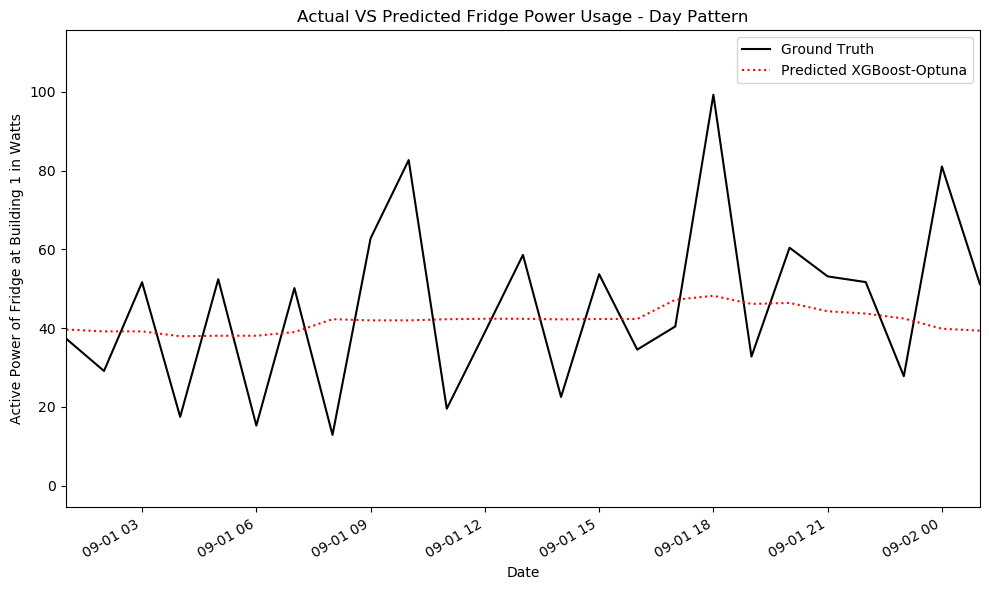

In [74]:
# Single Plot
y_pred = xgb_regressor_optuna.predict(X_val)
model = 'XGBoost-Optuna'
cycle = 'Day'
duration_single = day_duration

jin.plot_data(y_pred=y_pred, X_fact=X_val, y_fact=y_val, model=model, cycle=cycle, duration=duration_single, stage="val", iteration=2)

# Results

## Feature Importance

Most related to month and year features, which suggests the power usage of fridge at Building 1, is most dependence on long-term time features.

In [75]:
# Define variables
reg = xgb_regressor_optuna
model = 'XGBoost-Optuna'

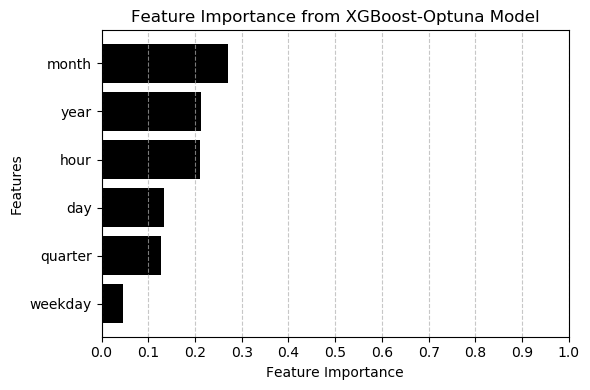

In [76]:
# Create a DataFrame with feature importances
fi = pd.DataFrame(
    index=reg.feature_names_in_,
    data=reg.feature_importances_,
    columns=['importance']
)

# Sort the features by importance
fi_sorted = fi.sort_values('importance')

# Set up figure and axes
fig, ax = plt.subplots(figsize=(6, 4))

# Plot horizontal bar chart
ax.barh(fi_sorted.index, fi_sorted['importance'], color='black')

# Customize labels and title
ax.set_xlabel('Feature Importance')
ax.set_ylabel('Features')
ax.set_title(f'Feature Importance from {model} Model')

ax.grid(axis='x', linestyle='--', alpha=0.7)
ax.set_xticks(np.arange(0, 1.1, 0.1))

plt.tight_layout()
plt.savefig(f'figures/final/B1_fridge_train_val_xgb_feature_importance.png', dpi=300)

## Forecast on Test Set

Prepare Test Set

In [77]:
X_test = create_features(test)[predictor_cols]
y_test = create_features(test)[target_col]

### Power Forecast Plots

✅ Figure saved as ./figures/final/B1_fridge_results_test_XGBoost-Optuna_Monday.png.


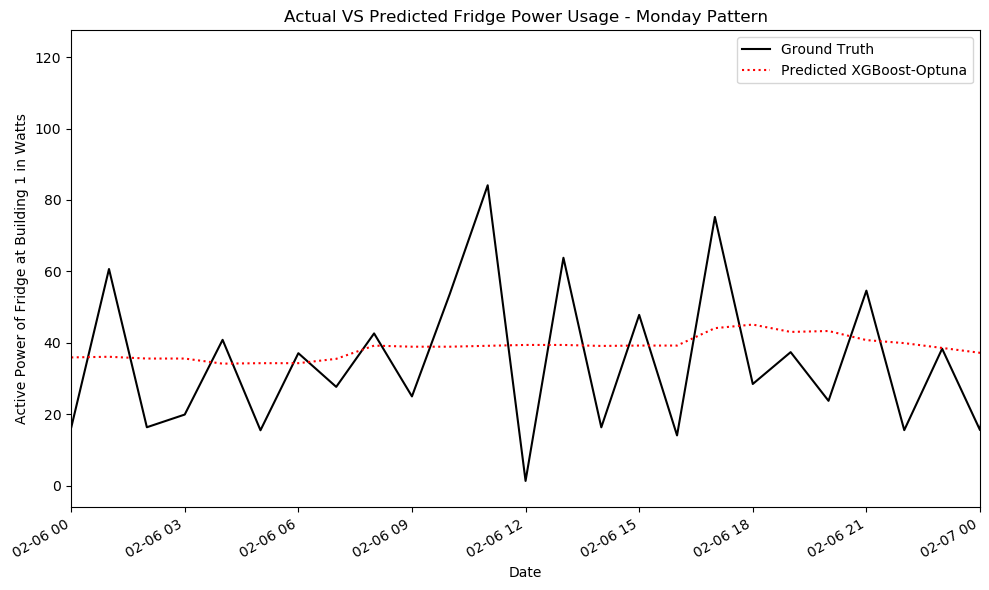

In [78]:
# Single Plot
y_test_pred = reg.predict(X_test)
cycle = 'Monday'
duration_single = ['2017-02-06', '2017-02-07']

jin.plot_data(y_pred=y_test_pred, X_fact=X_test, y_fact=y_test, model=model, cycle=cycle, duration=duration_single, stage="test", iteration='results')

✅ Figure saved as ./figures/final/B1_fridge_results_test_XGBoost-Optuna_Week.png.


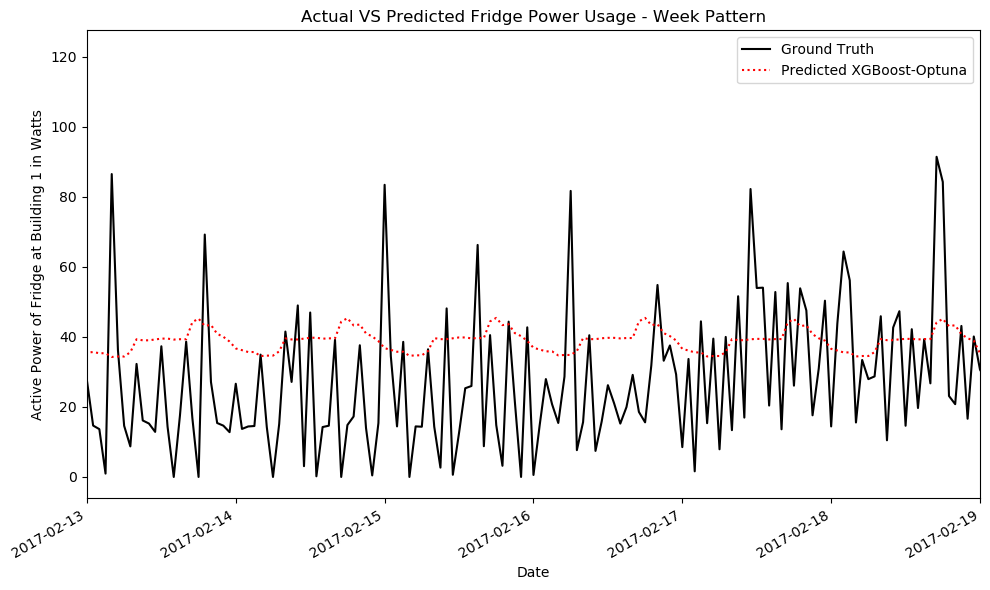

In [79]:
# Single Plot
y_test_pred = reg.predict(X_test)
cycle = 'Week'
duration_single = ['2017-02-13', '2017-02-19']

jin.plot_data(y_pred=y_test_pred, X_fact=X_test, y_fact=y_test, model=model, cycle=cycle, duration=duration_single, stage="test", iteration='results')

✅ Figure saved as ./figures/final/B1_fridge_power_overall_plot.png.


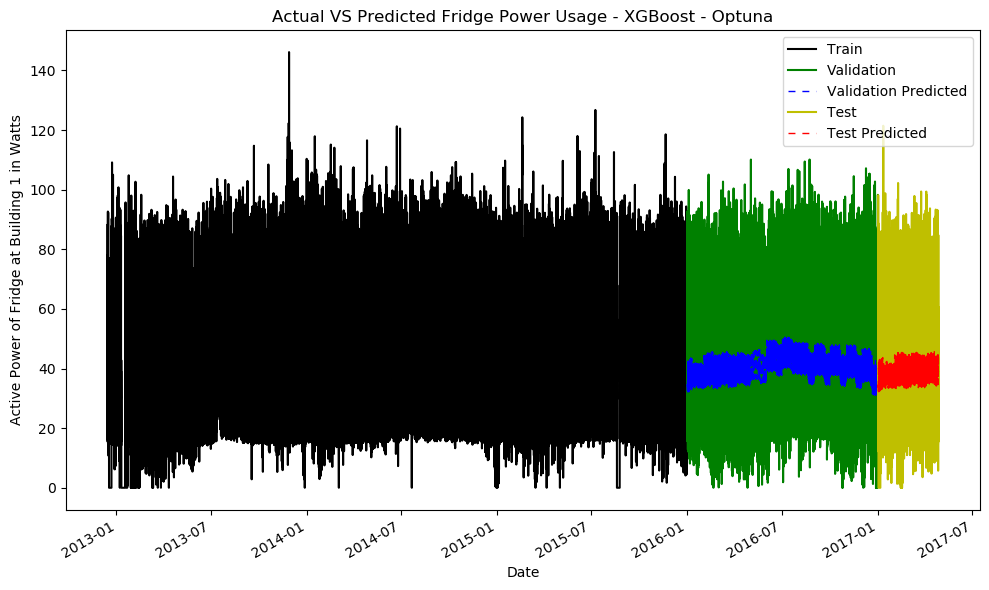

In [81]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(X_train.index, y_train, color='black', label='Train')
ax.plot(X_val.index, y_val, 'g-', label='Validation')
ax.plot(X_val.index, y_pred, 'b:', linewidth=1, linestyle=(0, (5, 5)), label='Validation Predicted')
ax.plot(X_test.index, y_test, 'y-', label='Test')
ax.plot(X_test.index, y_test_pred, 'r:', linewidth=1, linestyle=(0, (5, 5)), label='Test Predicted')

ax.set_xlabel('Date')
ax.set_ylabel('Active Power of Fridge at Building 1 in Watts')
plt.title(f'Actual VS Predicted Fridge Power Usage - XGBoost - Optuna')

fig.autofmt_xdate()

# Zoom in to later part
# ax.set_xlim(pd.to_datetime('2013-08-01'), pd.to_datetime('2013-10-10'))

# Plot the legend
plt.legend()

plt.tight_layout()
plt.savefig(f'./figures/final/B1_fridge_power_overall_plot.png', dpi=300)
print(f"✅ Figure saved as ./figures/final/B1_fridge_power_overall_plot.png.")

### Cost Forecast Plot

In [82]:
price_per_kwh = 0.2351 # £

In [83]:
y_pred_datetime = pd.Series(y_pred, index=y_val.index)
y_test_pred_datetime = pd.Series(y_test_pred, index=y_test.index)

In [84]:
monthly_cost_train = jin.calculate_energy_monthly_cost(hourly_power_watts=y_train, price_per_kwh=price_per_kwh)
monthly_cost_val = jin.calculate_energy_monthly_cost(hourly_power_watts=y_val, price_per_kwh=price_per_kwh)
monthly_cost_test = jin.calculate_energy_monthly_cost(hourly_power_watts=y_test, price_per_kwh=price_per_kwh)
monthly_cost_val_pred = jin.calculate_energy_monthly_cost(hourly_power_watts=y_pred_datetime, price_per_kwh=price_per_kwh)
monthly_cost_test_pred = jin.calculate_energy_monthly_cost(hourly_power_watts=y_test_pred_datetime, price_per_kwh=price_per_kwh)

✅ Figure saved as ./figures/final/B1_fridge_cost_overall_plot.png.


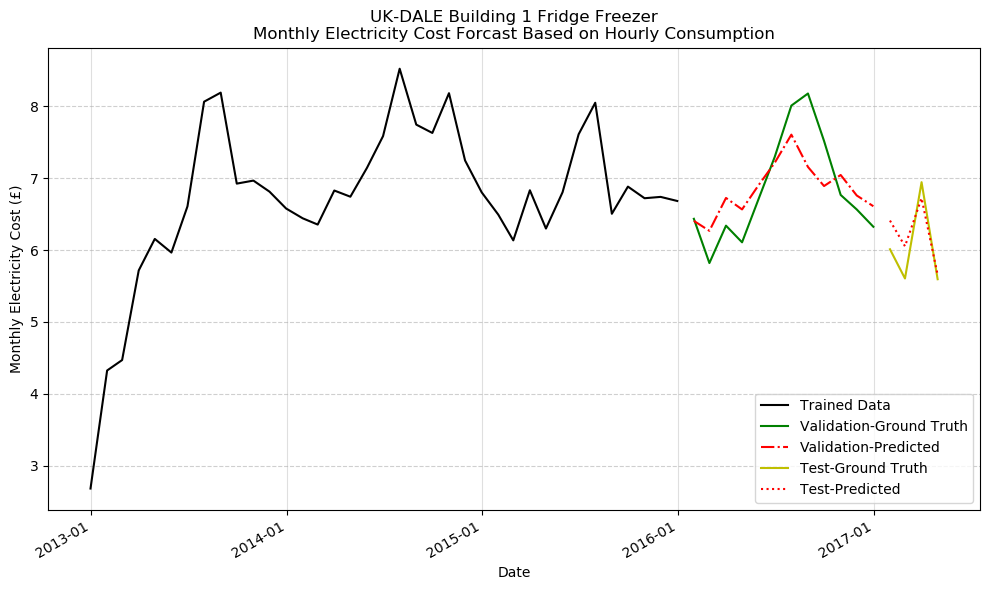

In [85]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(10,6))

ax.plot(monthly_cost_train.index, monthly_cost_train.values, color='black', ls='-', label='Trained Data')
ax.plot(monthly_cost_val.index, monthly_cost_val.values, color='green', ls='-', label='Validation-Ground Truth')
ax.plot(monthly_cost_val_pred.index, monthly_cost_val_pred.values, color='red', ls='-.', label='Validation-Predicted')
ax.plot(monthly_cost_test.index, monthly_cost_test.values, color='y', ls='-', label='Test-Ground Truth')
ax.plot(monthly_cost_test_pred.index, monthly_cost_test_pred.values, color='red', ls=':', label='Test-Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Monthly Electricity Cost (£)')
plt.title('UK-DALE Building 1 Fridge Freezer\nMonthly Electricity Cost Forcast Based on Hourly Consumption')

# Add monthly grid lines
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))  # or YearLocator, DayLocator

fig.autofmt_xdate()
ax.grid(axis='x', linestyle='-', alpha=0.4)
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.legend()

plt.tight_layout()

plt.savefig(f'./figures/final/B1_fridge_cost_overall_plot.png', dpi=300)
print(f"✅ Figure saved as ./figures/final/B1_fridge_cost_overall_plot.png.")

# Further Discussion

- Long-Term Feature Contribution:
The feature importance plot suggests that long-term features, especially `month`, contribute more significantly to the model's predictive performance. To enhance accuracy, consider incorporating additional long-term contextual features such as weather data.

- Model Evaluation Strategy:
This project currently relies on a train-test split for evaluation. Implementing `cross-validation` would provide a more robust assessment of model performance and reduce the risk of overfitting.

- Electricity Price Assumptions:
A fixed `electricity price` of 23.51p/kWh was used throughout the analysis. However, electricity prices often fluctuate over time or vary based on tariffs. Future work could improve cost prediction accuracy by including electricity price as a dynamic feature in the model.

# References

-	Rl.ac.uk. (2017). UKERC Energy Data Centre - UK Domestic Appliance Level Electricity (UK-DALE). [online] Available at: https://data.ukedc.rl.ac.uk/browse/edc/efficiency/residential/EnergyConsumption/Domestic/UK-DALE-2017/ReadMe_DALE-2017.html [Accessed 12 Apr. 2025].

-	Kelly, J. (2024). Jack Kelly. [online] Jack Kelly. Available at: https://jack-kelly.com/ [Accessed 26 Mar. 2025].

-	Kelly, J. (2015). NeuralNILM. [online] Jack-kelly.com. Available at: https://jack-kelly.com/EPRI_NeuralNILM/?utm_source=chatgpt.com#/ [Accessed 26 Mar. 2025].

-	GitHub.(2025). JackKelly/lets_make_it_super_easy_to_use_weather_forecast_data: Let’s make it super easy to use weather forecast data. [online] Available at: https://github.com/JackKelly/lets_make_it_super_easy_to_use_weather_forecast_data [Accessed 26 Mar. 2025].

-	GitHub. (2025). building-data-genome-project-2/notebooks/00_All-meters-dataset.ipynb at master · buds-lab/building-data-genome-project-2. [online] Available at: https://github.com/buds-lab/building-data-genome-project-2/blob/master/notebooks/00_All-meters-dataset.ipynb [Accessed 26 Mar. 2025].

-	University of Strathclyde. (2016). REFIT: Electrical Load Measurements (Cleaned). [online] Available at: https://pureportal.strath.ac.uk/en/datasets/refit-electrical-load-measurements-cleaned [Accessed 26 Mar. 2025].

-	GitHub. (2025). kehkok/nilmtk-ukdale: Group of Apprentices to learn NILMTK with UK-DALE. [online] Available at: https://github.com/kehkok/nilmtk-ukdale [Accessed 26 Mar. 2025].

-	Magdalini Eirinaki, Iraklis Varlamis, Janhavi Dahihande, Jaiswal, A., Akshay Anil Pagar and Ajinkya Thakare (2022). Real-time recommendations for energy-efficient appliance usage in households. Frontiers in Big Data, [online] 5. doi: https://doi.org/10.3389/fdata.2022.972206.

-	Gokagglers (2017). Appliances Energy Prediction. [online] Kaggle.com. Available at: https://www.kaggle.com/datasets/loveall/appliances-energy-prediction/data [Accessed 26 Mar. 2025].

-	Readthedocs.io. (2025). Welcome to NILM Metadata’s documentation! — NILM Metadata 0.2.0 documentation. [online] Available at: https://nilm-metadata.readthedocs.io/en/latest/ [Accessed 1 Apr. 2025].

-	GitHub. (2025). JackKelly/ukdale_plots: Plots (using NILMTK) for my UK-DALE dataset paper. [online] Available at: https://github.com/JackKelly/ukdale_plots [Accessed 1 Apr. 2025].

-	GitHub. (2017). nilmtk/nilm_metadata: A schema for modelling meters, measurements, appliances, buildings etc. [online] Available at: https://github.com/nilmtk/nilm_metadata/tree/master [Accessed 2 Apr. 2025].

-	GitHub. (2025). marcopeix/TimeSeriesForecastingInPython. [online] Available at: https://github.com/marcopeix/TimeSeriesForecastingInPython [Accessed 12 Apr. 2025].

-	Youtube.com. (2025). Available at: https://www.youtube.com/watch?v=vV12dGe_Fho&t=1159s [Accessed 12 Apr. 2025].